# T2.2

Gabriela Bevilacqua - 1511241
<br>
Joyce Araújo - 1213110
<br>
<br>
Predição de dados sobre o dataset "Individual household electric power consumption" da UCI.

## Eletric Power Consuption DataSet  Information

DataSet from University of California Irvine (UCI)
<br>
Available at https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption
<br><br>
**Attribute Information:**
<br>
1.date: Date in format dd/mm/yyyy
<br>
2.time: time in format hh:mm:ss 
<br>
3.global_active_power: household global minute-averaged active power (in kilowatt) 
<br>
4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) 
<br>
5.voltage: minute-averaged voltage (in volt) 
<br>
6.global_intensity: household global minute-averaged current intensity (in ampere) 
<br>
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a 
dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
<br>
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a 
washing-machine, a tumble-drier, a refrigerator and a light. 
<br>
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


### Opening Dataset

In [58]:
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning libraries and functions
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import metrics

#### DataFrame

In [59]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

#### Adapting Data

In [60]:
# Preenchendo as células que contém nan (not a number) com a média dos valores
columns_fill = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for column in columns_fill:
    df[column].fillna((df[column].mean()), inplace=True)

In [61]:
# Criando uma nova coluna para predição de dados
# Low or High Global Active Power Consume
df['Global_active_power_round'] = pd.Series(np.where(df['Global_active_power'].values >= 1.0, 1, 0), df.index)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_round
dt,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,1
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1


#### Checking data distribution

Text(0.5,1,'GAP distribution')

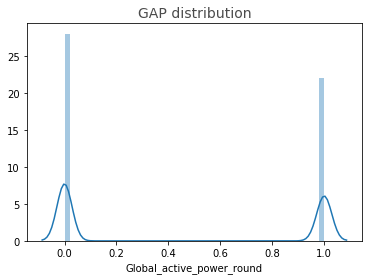

In [62]:
import warnings
warnings.filterwarnings('ignore')

g = sns.distplot(df['Global_active_power_round']);
g.axes.set_title('GAP distribution', fontsize=14, alpha=0.7)

### Data Prediction
Predizer o consumo de energia "futuro" com base nas datas (dd/mm/yyyy).
<br>
Para tentar melhorar tanto a visualização dos dados quanto a predição, os dados foram separados por dia e dentro de um dia por períodos (madrugada, manhã, tarde, noite)

#### Spliting data into days and day periods (dawn, morning, afternoon, night)

In [63]:
# Spliting dataseries by hour
df_hour_series = df.Global_active_power.resample('H').mean()
df_by_hour = pd.DataFrame(df_hour_series)

In [64]:
import datetime

# Consumo de energia por dia divido em periodos dos dia 
gap_per_day_period = {1: [], 2: [], 3: [], 4: []}

_period = -1
start_index = -1
end_index = -1

i = 0

for index, row in df_by_hour.iterrows():
    dt = index
    hr = index.hour
    end_index = i
            
    if(hr >= 0 and hr < 6):
        period = 1 # Madrugada
    elif(hr >= 6 and hr < 12):
        period = 2 # Manha
    elif(hr >= 12 and hr < 18):
        period = 3 # Tarde
    elif(hr >= 18 and hr < 24):
        period = 4 # Noite
        
    if(period != _period and _period != -1):
        gap_avg = df_by_hour['Global_active_power'].iloc[start_index : end_index].mean(axis=0)
        
        gap_per_day_period[period].append([dt, gap_avg])
        
        _period = period
        start_index = i
    
    if(_period == -1):
        start_index = i
        _period = period
        
    i += 1


#### Agrouping data into a dataframe

In [65]:
consume_at_dawn = pd.DataFrame(data=gap_per_day_period[1], columns = ['Date', 'GAP'])
consume_at_morning = pd.DataFrame(data=gap_per_day_period[2], columns = ['Date', 'GAP'])
consume_at_afternoon = pd.DataFrame(data=gap_per_day_period[3], columns = ['Date', 'GAP'])
consume_at_night = pd.DataFrame(data=gap_per_day_period[4], columns = ['Date', 'GAP'])

frames = [consume_at_dawn, consume_at_morning, consume_at_afternoon, consume_at_night]

consume_per_period = pd.concat(frames, keys=['DAWN', 'MORNING', 'AFTERNOON', 'NIGHT'])
consume_per_period.head()

Date       GAP
DAWN 0 2006-12-17  2.936533
     1 2006-12-18  2.493917
     2 2006-12-19  2.253900
     3 2006-12-20  1.588983
     4 2006-12-21  3.124622

#### Making date conversions

In [66]:
import datetime as dt

consume_per_period['Date'] = consume_per_period['Date'].map(dt.datetime.toordinal)

In [67]:
consume_per_period.describe()

,Date,GAP
count,5765.000000,5765.000000
mean,733381.874935,1.092072
std,416.089139,0.698318
min,732661.000000,0.161300
25%,733022.000000,0.455789
50%,733382.000000,0.990694
75%,733742.000000,1.551678
max,734102.000000,4.418233


#### Making GAP conversions (binary)

In [68]:
consume_per_period['GAP'] = pd.Series(np.where(consume_per_period['GAP'].values >= 1.0, 1, 0), consume_per_period.index)

consume_per_period.head()

Date  GAP
DAWN 0  732662    1
     1  732663    1
     2  732664    1
     3  732665    1
     4  732666    1

Text(0.5,1,'GAP distribution')

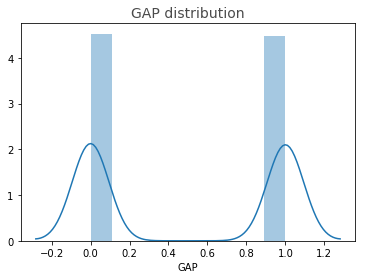

In [69]:
# Visualizing GAP Low/High Consume distribution
g = sns.distplot(consume_per_period['GAP']);
g.axes.set_title('GAP distribution', fontsize=14, alpha=0.7)

#### Predicting energy consume (high or low) by date

In [70]:
def define_training_test(seed_number, X, Y, size):
    # Separar os conjuntos de treino e teste
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=size, random_state=np.random.seed(seed_number), shuffle=False)

    return X_train, Y_train, X_test, Y_test

In [71]:
def logistic_regression_graph(period_key):
    # Definir as datas para predi��o do consumo de energia e o dataset
    dataset = consume_per_period.loc[period_key]
    source_ft = ['Date']
    target_ft = 'GAP'
    size = 0.3
    
    # Separar os conjuntos de treino e teste
    X = np.array(dataset[source_ft])
    Y = np.array(dataset[target_ft])

    X_train, Y_train, X_test, Y_test = define_training_test(101, X, Y, size)

    # Criar modelo para Regress�o Linear
    regr = sk.linear_model.LogisticRegression()

    # Treinar o modelo
    regr.fit(X_train, Y_train)

    # Fazer predi��es para o conjunto de teste
    Y_pred = regr.predict(X_test)
    
    # Informa��es sobre a regress�o e erro/vari�cia dos dados
    print('Coefficients:     ', regr.coef_)
    print('Intercept:        ', regr.intercept_)
    print('Mean squared error: %.2f' % mean_squared_error(Y_test, Y_pred))
    print('Variance score:     %.2f' % r2_score(Y_test, Y_pred))
    print('Accuracy:          ', regr.score(X_test, Y_test))

    # Fazer scatterplot plotando a linha de regress�o
    sns.regplot(x=X_test, y=Y_test, scatter_kws={'alpha':0.3}, logistic = True)
#     plt.plot(X_test, Y_pred, color='k', linewidth=1)

    # Ajustar datas no eixo x (converter de ordinal para data)
    ax = plt.gca()
    xticks = ax.get_xticks()
    ax.set_xticklabels([dt.datetime.fromordinal(int(tm)).strftime('%Y-%m-%d\n %H:%M:%S') for tm in xticks], rotation=50)

    # Definir periodo do dia
    if(period_key == 'DAWN'):
        period_name = 'Madrugada'
    elif(period_key == 'MORNING'):
        period_name = 'Manh�'
    elif(period_key == 'AFTERNOON'):
        period_name = 'Tarde'
    elif(period_key == 'NIGHT'):
        period_name = 'Noite'
    
    title = 'Consumo de Energia de '
        
    # Adicionar t�tulo e x/y labels
    ax.set_title(title + period_name)
    ax.set_ylabel('Consumo de Energia')

#     plt.scatter(X_test, Y_test, alpha=0.3)
#     plt.plot(X_test, Y_pred, color='k', linewidth=1)

    plt.show()

In [72]:
warn_set = np.seterr(divide='ignore', invalid='ignore')

#### Energy consume by period

Coefficients:      [[1.50558371e-06]]
Intercept:         [2.0538747e-12]
Mean squared error: 0.21
Variance score:     -0.26
Accuracy:           0.792147806004619


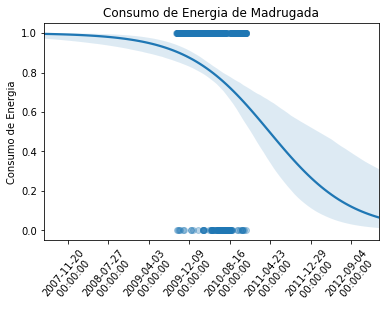

In [73]:
logistic_regression_graph('DAWN')

Coefficients:      [[-3.41905978e-06]]
Intercept:         [-4.66249433e-12]
Mean squared error: 0.07
Variance score:     -0.07
Accuracy:           0.9330254041570438


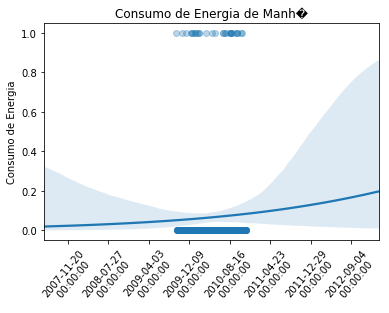

In [74]:
logistic_regression_graph('MORNING')

Coefficients:      [[9.09051348e-07]]
Intercept:         [1.23986605e-12]
Mean squared error: 0.27
Variance score:     -0.37
Accuracy:           0.7297921478060047


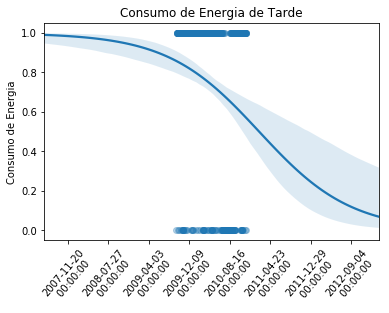

In [75]:
logistic_regression_graph('AFTERNOON')

Coefficients:      [[-3.45245925e-07]]
Intercept:         [-4.7072888e-13]
Mean squared error: 0.55
Variance score:     -1.21
Accuracy:           0.45265588914549654


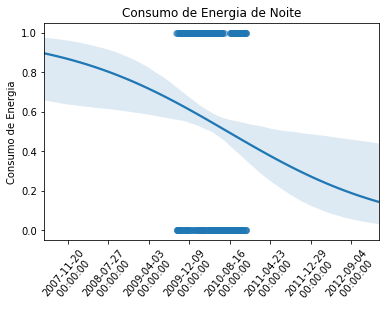

In [76]:
logistic_regression_graph('NIGHT')

#### Predictions Conclusions
Como descrito antes na exploração e análise de dados, parece não existir um padrão muito claro sobre o consumo de energia.
<br>
<br>
Isso deve acontecer porque a rotina das pessoas apesar de parecida nem sempre é a mesma, pode acontecer algo que a pessoa precise voltar mais cedo pra casa ou mais tarde, viagens... Enfim, o consumo de energia é extremamente dependente da pessoa que mora na residência. Tanto da sua rotina, quanto do seu humor, suas necessidades e entre outros.
<br>
<br>
Por esse motivo foi muito difícil fazer uma predição do consumo que tivesse resultado razoável e cuja predição fizesse sentido.
<br>
<br>
Apesar dos vários atributos de cada instância, foi escolhido prever o consumo de energia com base na data. Pois conceitualmente não faria sentido prever o consumo de energia com base em dados sobre a própria energia pois em uma previsão de dados novos, essas informações não existiriam, elas somente seriam computadas durante o uso da energia e por isso não seriam bons dados para uma predição real.
<br>
<br>
Para tentar encontrar um padrão ou uma predição melhor, os dados foram previstos com base no período do dia. Assim foi feita uma regressão logística, utilizando a data como dado preditivo e o consumo de energia como dado a ser predito. Para facilitar essa predição o consumo de energia foi convertido de float para binário (1 ou 0), prevendo então como saída o consumo alto ou baixo de energia. Sendo o critério de consumo alto uma média de consumo superior a 1.0. (Esse critério foi escolhido descrevendo os dados dos dataframes criados).
<br>
<br>
Como resultado as regressões por período do dia foram razoalmente boas, considerando as tentativas anteriores com regressão linear e sem separar por períodos do dia. O período da manhã foi o mais "estável" e que obteve melhor resultado na predição de dados. Os períodos da tarde e da madrugada tiveram uma predição boa também e o período da noite ficou com a pior previsão.
<br><br>
Apesar da acurácia ter sido boa para alguns modelos e o erro médio quadrático (mean squared error) também, não foi possível melhorar a variância (r2 score) que ficou muito ruim para todos os modelos.